In [ ]:
# Install library dependencies (versions fixed to those used at time of publication)
#
%pip install DeepXDE==1.7.1

# Uncomment and run these lines if tensorflow, numpy, and matplotlib are not already installed.
# In most execution environments (Colab, tensorflow Docker image, etc.), these are already
# pre-installed on the OS.
#
#%pip install numpy==1.23.5 \
#             matplotlib==3.7.1 \
#             tensorflow==2.12.0

Reference wave height:


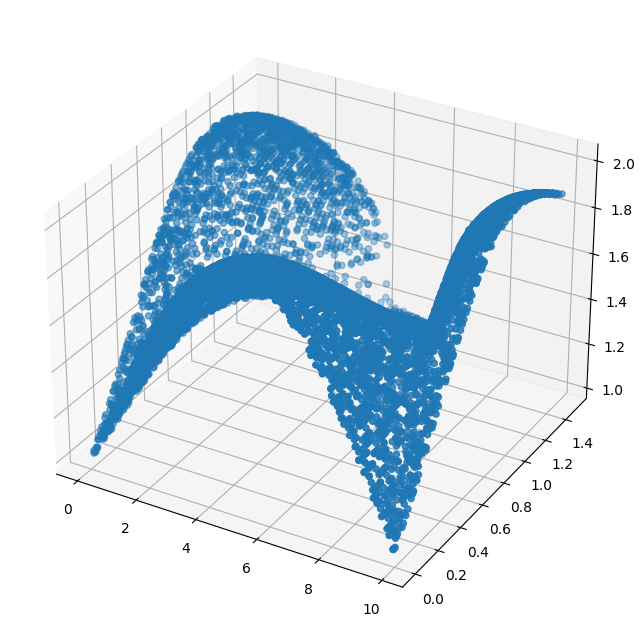

Reference velocity:


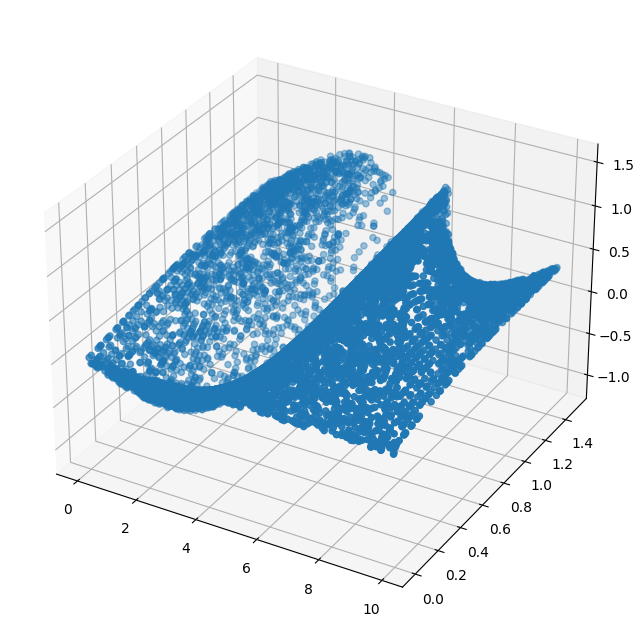

Reference bathymetry:


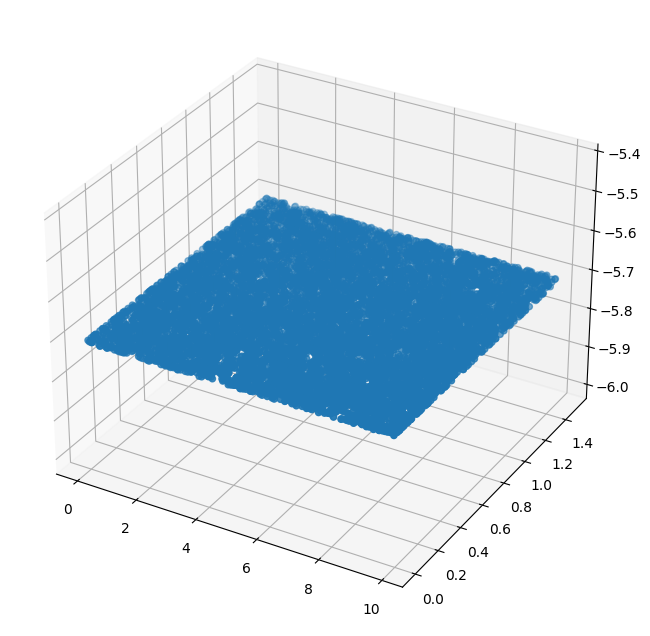

Set the default float type to float32
[-5.71059314]
Compiling model...
Building feed-forward neural network...
'build' took 0.078051 s



2023-04-11 01:49:40.671545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-11 01:49:40.671797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-11 01:49:40.671919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

'compile' took 0.889800 s

Initializing variables...
Training model...

Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
0         [4.41e-03, 3.69e+00, 1.32e+00, 1.69e-01, 3.05e-01, 1.01e-01, 2.34e-01, 1.39e-01, 1.38e+00, 2.86e-01, 4.04e+01]    [4.41e-03, 3.69e+00, 1.32e+00, 1.69e-01, 3.05e-01, 1.01e-01, 2.34e-01, 1.39e-01, 1.38e+00, 2.86e-01, 4.04e+01]    []  
1000      [2.62e-02, 1.85e-01, 3.77e-02, 1.01e-01, 1.23e-01, 1.36e-03, 2.15e-03, 6.61e-04, 6.63e-02, 2.55e-01, 1.06e-02]    [2.62e-02, 1.85e-01, 3.77e-02, 1.01e-01, 1.23e-01, 1.36e-03, 2.15e-03, 6.61e-04, 6.63e-02, 2.55e-01, 1.06e-02]    []  
2000      [2.39e-02, 1.70e-01, 3.64e-02, 9.97e-02, 1.25e-01, 6.00e-04, 9.15e-04, 2.20e-04, 6.33e-02, 2.52e-01, 9.93e-03]    [2.39e-02, 1.70e-01, 3.64e-02, 9.97e-02, 1.25e-01, 6.00e-04, 9.15e-0

33000     [2.65e-02, 5.09e-02, 4.24e-02, 2.30e-02, 1.55e-03, 8.49e-04, 4.23e-05, 9.25e-05, 1.07e-01, 5.63e-02, 2.47e-03]    [2.65e-02, 5.09e-02, 4.24e-02, 2.30e-02, 1.55e-03, 8.49e-04, 4.23e-05, 9.25e-05, 1.07e-01, 5.63e-02, 2.47e-03]    []  
34000     [2.51e-02, 5.98e-02, 4.54e-02, 1.94e-02, 1.08e-03, 1.62e-03, 1.59e-04, 3.60e-04, 1.10e-01, 6.00e-02, 2.81e-03]    [2.51e-02, 5.98e-02, 4.54e-02, 1.94e-02, 1.08e-03, 1.62e-03, 1.59e-04, 3.60e-04, 1.10e-01, 6.00e-02, 2.81e-03]    []  
35000     [2.61e-02, 5.07e-02, 4.28e-02, 2.19e-02, 1.22e-03, 6.10e-04, 8.96e-05, 1.47e-04, 1.10e-01, 5.46e-02, 2.14e-03]    [2.61e-02, 5.07e-02, 4.28e-02, 2.19e-02, 1.22e-03, 6.10e-04, 8.96e-05, 1.47e-04, 1.10e-01, 5.46e-02, 2.14e-03]    []  
36000     [2.37e-02, 8.60e-02, 4.60e-02, 2.12e-02, 1.85e-03, 1.20e-04, 4.57e-04, 8.74e-05, 1.11e-01, 5.68e-02, 1.67e-03]    [2.37e-02, 8.60e-02, 4.60e-02, 2.12e-02, 1.85e-03, 1.20e-04, 4.57e-04, 8.74e-05, 1.11e-01, 5.68e-02, 1.67e-03]    []  
37000     [2.58e-02, 4.26e-0

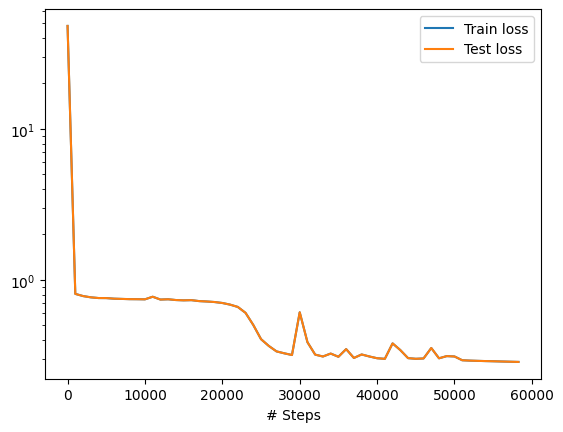

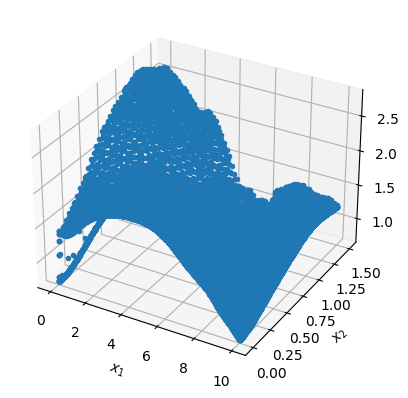

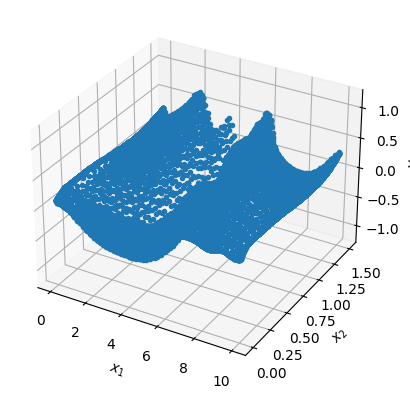

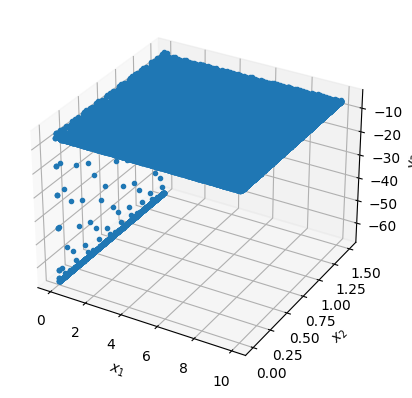

L2 relative error: 0.8524350451038116


In [11]:
import deepxde as dde
import numpy as np

from pinn import swe_1d
from csv_utils import load_data, plot_point_cloud, PhysicalQuantity

# Plot reference pseudospectral solution
#
print('Reference wave height:')
plot_point_cloud(load_data(sample_size=50000), quantity=PhysicalQuantity.HEIGHT)
print('Reference velocity:')
plot_point_cloud(load_data(sample_size=50000), quantity=PhysicalQuantity.VELOCITY)
print('Reference bathymetry:')
plot_point_cloud(load_data(sample_size=50000), quantity=PhysicalQuantity.BATHYMETRY)

# Set random seed to 0 to allow for reproducable randomness in results
#
dde.config.set_random_seed(0)

# Set default float to 32-bit since Tensorflow seems to like that better
# when training on a GPU
#
dde.config.set_default_float('float32')

# Generate domain
#
x_min, x_max = (0, 10)
t_min, t_max = (0, 1.5)

geom = dde.geometry.Interval(x_min, x_max)
timedomain = dde.geometry.TimeDomain(t_min, t_max)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Domain boundary functions
#
def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_min)


def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_max)

# Point-set boundary condition for physical quantities of interest. In a real-world application, this might 
# correspond to measured data at specific collocation points.
#
all_measured_data = load_data()
observed_measurement_data = load_data(100)  # Load 100 random "measurements"

bc_h_obs = dde.icbc.PointSetBC(observed_measurement_data[:, 0:2], observed_measurement_data[:, 2:3], component=0)
bc_v_obs = dde.icbc.PointSetBC(observed_measurement_data[:, 0:2], observed_measurement_data[:, 3:4], component=1)

print(all_measured_data[0, 4:5])
bc_alpha_obs = dde.icbc.PointSetBC(observed_measurement_data[:, 0:2], observed_measurement_data[:, 4:5], component=2)
# bc_alpha_obs = dde.icbc.DirichletBC(geomtime, lambda x: all_measured_data[0, 4:5], lambda _, on_boundary: on_boundary, component=2)
                                    
# Periodic boundary conditions for height and velocity, respectively
#
bc_h = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, component=0, derivative_order=0)
bc_v = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, component=1, derivative_order=0) 

# Periodic boundary conditions for height and velocity derivatives, respectively
#
bc_h_x = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, component=0, derivative_order=1)
bc_v_x = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, component=1, derivative_order=1)

# Initial condition for wave height
#
ic_h = dde.icbc.IC(
    geomtime,
    lambda omega: 1 + np.sin(omega[:, 0:1] * np.pi / 10),
    lambda _, on_initial: on_initial,
    component=0,
)

# Initial condition for wave velocity
#
ic_v = dde.icbc.IC(
    geomtime,
    lambda omega: omega[:, 0:1] * 0,
    lambda _, on_initial: on_initial,
    component=1,
)

# Solve system with specified BCs and ICs
#
swe_1d(geomtime, [
    ic_h,
    ic_v
], [
    bc_h, 
    bc_v, 
    bc_h_x, 
    bc_v_x,
    bc_h_obs, 
    bc_v_obs,
    bc_alpha_obs, 
], samples=load_data(500), iterations=50000)